https://rdpharr.github.io/project_notes/baseball/benchmark/webscraping/brier/accuracy/calibration/machine%20learning/2020/09/20/baseball_project.html


In [1]:
import requests
import re
import datetime as dt
url = 'https://www.baseball-reference.com/leagues/MLB/2019-schedule.shtml'
resp = requests.get(url)
# All the H3 tags contain day names
days = re.findall("<h3>(.*2019)</h3>", resp.text)
dates = [dt.datetime.strptime(d,"%A, %B %d, %Y") for d in days]
print("Number of days MLB was played in 2019:", len(dates))

Number of days MLB was played in 2019: 210


In [2]:
from bs4 import BeautifulSoup as bs
game_data = []
for d in dates:
    # get the web page with game data on it
    game_day = d.strftime('%Y-%m-%d')
    url = f'https://www.covers.com/Sports/MLB/Matchups?selectedDate={game_day}'
    resp = requests.get(url)

    # parse the games
    scraped_games = bs(resp.text).findAll('div',{'class':'cmg_matchup_game_box'})
    for g in scraped_games:
        game = {}
        game['home_moneyline'] = g['data-game-odd']
        game['date'] = g['data-game-date']
        try:
            game['home_score'] =g.find('div',{'class':'cmg_matchup_list_score_home'}).text.strip()
            game['away_score'] =g.find('div',{'class':'cmg_matchup_list_score_away'}).text.strip()
        except:
            game['home_score'] =''
            game['away_score'] =''

        game_data.append(game)
        if len(game_data) % 500==0:
            #show progress
            print(dt.datetime.now(), game_day, len(game_data))
print("Done! Games downloaded:", len(game_data))

2023-08-21 19:38:30.933656 2019-05-02 500
2023-08-21 19:39:10.010530 2019-06-08 1000
2023-08-21 19:39:48.488920 2019-07-18 1500
2023-08-21 19:40:28.732850 2019-08-24 2000
2023-08-21 19:41:09.996497 2019-10-03 2500
Done! Games downloaded: 2533


In [3]:
game_data[0]

{'home_moneyline': '',
 'date': '2019-03-20 05:35:00',
 'home_score': '7',
 'away_score': '9'}

In [4]:
import pickle
pickle.dump(game_data, open('covers_data.pkl','wb'))

In [5]:
from sklearn.metrics import accuracy_score

# the actual outcome of the game, true if the the home team won
outcomes = []
# predictions derived from moneyline odds. True if the home team was the favorite
predictions = []
# probability the home team will win, derived from moneyline odds
# derived from formulas at https://www.bettingexpert.com/academy/advanced-betting-theory/odds-conversion-to-percentage
probabilities = []

for d in game_data:
    try:
        moneyline = int(d['home_moneyline'])
        home_score = int(d['home_score'])
        away_score = int(d['away_score'])
    except:
        #incomplete data
        continue
    if moneyline==100:
        # it's rare to have a tossup since covers is averaging the odds from several sports books
        # but we'll exclude them from our calculations
        continue

    # convert moneyline odds ot their implied probabilities
    if moneyline<0:
        probabilities.append(-moneyline/(-moneyline + 100))
    elif moneyline>100:
        probabilities.append(100/(moneyline + 100))

    outcomes.append(home_score>away_score)
    predictions.append(moneyline<0)

print("Sportsbook accuracy (excluding tossups): {0:.2f}%".format(100*accuracy_score(outcomes,predictions)))

Sportsbook accuracy (excluding tossups): 100.00%


SportsBook	Accuracy:1.0000	 Brier Loss: 0.0084


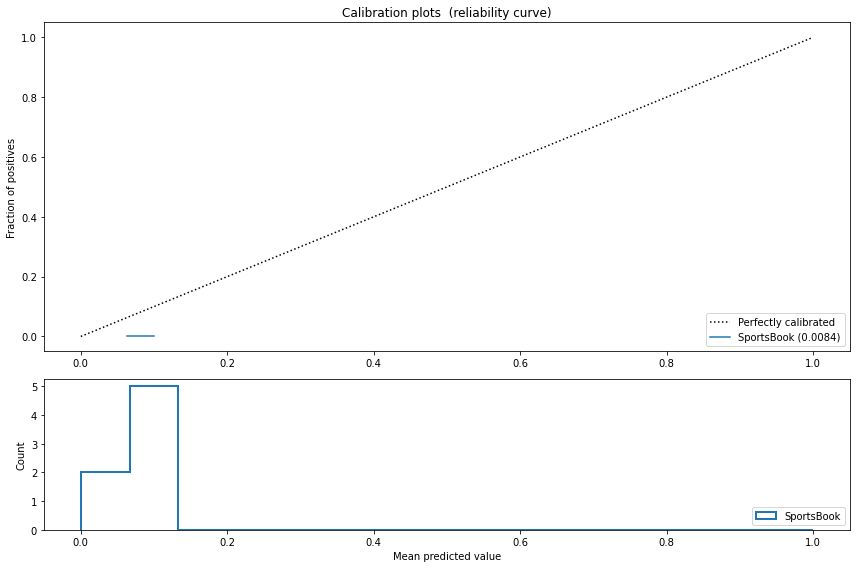

In [6]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, brier_score_loss
import matplotlib.pyplot as plt

def cal_curve(data, bins):
    # adapted from:
    #https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
    fig = plt.figure(1, figsize=(12, 8))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for y_test, y_pred, y_proba, name in data:
        brier = brier_score_loss(y_test, y_proba)
        print("{}\tAccuracy:{:.4f}\t Brier Loss: {:.4f}".format(
            name, accuracy_score(y_test, y_pred), brier))
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, y_proba, n_bins=bins)
        ax1.plot(mean_predicted_value, fraction_of_positives,
                 label="%s (%1.4f)" % (name, brier))
        ax2.hist(y_proba, range=(0, 1), bins=bins, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

data = [(outcomes, predictions, probabilities, 'SportsBook')]
cal_curve(data, 15)

In [7]:
import pickle
pickle.dump((outcomes,predictions, probabilities), open('baseline.pkl','wb'))

In [8]:
import requests
from bs4 import BeautifulSoup as bs

game_links = []
for current_year in range(2016,2021):
    url = f"https://www.baseball-reference.com/leagues/MLB/{current_year}-schedule.shtml"
    resp = requests.get(url)
    soup=bs(resp.text)
    games = soup.findAll('a',text='Boxscore')
    game_links.extend([x['href'] for x in games])
print("Number of games to download: ", len(game_links))
game_links[0]

Number of games to download:  10812


'/boxes/KCA/KCA201604030.shtml'

In [15]:
# these are functions related to parsing the baseball reference page

# def get_game_summary(soup, game_id):
#     game = {'game_id': game_id}
#     scorebox = soup.find('div', {'class':'scorebox'})
#     teams = scorebox.findAll('a',{'itemprop':'name'})
#     game['away_team_abbr'] = teams[0]['href'].split('/')[2]
#     game['home_team_abbr'] = teams[1]['href'].split('/')[2]
#     meta = scorebox.find('div', {'class':'scorebox_meta'}).findAll('div')
#     game['date'] = meta[0].text.strip()
#     game['start_time'] = meta[1].text[12:-6].strip()
#     return game

def get_game_summary(soup, game_id):
    game = {'game_id': game_id}

    date_element = soup.find('h3')  # Find the <h3> element containing the date
    if date_element:
        game['date'] = date_element.text.strip()  # Extract the date text and remove leading/trailing spaces

    scorebox = soup.find('div', {'class': 'scorebox'})
    teams = scorebox.findAll('a', {'itemprop': 'name'})

    for team_link in teams:
        team_abbr = team_link['href'].split('/')[2]  # Extract the team abbreviation from the URL
        if 'away' in team_link['href']:
            game['away_team_abbr'] = team_abbr
        elif 'home' in team_link['href']:
            game['home_team_abbr'] = team_abbr

    meta = scorebox.find('div', {'class': 'scorebox_meta'}).findAll('div')
    game['start_time'] = meta[1].text[12:-6].strip()

    return game

def get_table_summary(soup, table_no):
    stats_tables = soup.findAll('table', {'class':'stats_table'})
    t = stats_tables[table_no].find('tfoot')
    summary = {x['data-stat']:x.text.strip() for x in t.findAll('td')}
    return summary

def get_pitcher_data(soup, table_no):
    stats_tables = soup.findAll('table', {'class':'stats_table'})
    t = stats_tables[table_no]
    data = []
    rows = t.findAll('tr')[1:-1] # not the header and footer rows
    for r in rows:
        summary = {x['data-stat']:x.text.strip() for x in r.findAll('td')}
        summary['name'] = r.find('th',{'data-stat':'player'}).find('a')['href'].split('/')[-1][:-6].strip()
        data.append(summary)
    return data

def process_link(url):
    resp = requests.get(url)
    game_id = url.split('/')[-1][:-6]

    # strange preprocessing routine
    uncommented_html = ''
    for h in resp.text.split('\n'):
        if '<!--     <div' in h: continue
        if h.strip() == '<!--': continue
        if h.strip() == '-->': continue
        uncommented_html += h + '\n'

    soup = bs(uncommented_html)
    data = {
        'game': get_game_summary(soup, game_id),
        'away_batting': get_table_summary(soup, 1),
        'home_batting':get_table_summary(soup, 2),
        'away_pitching':get_table_summary(soup, 3),
        'home_pitching':get_table_summary(soup, 4),
        'away_pitchers': get_pitcher_data(soup, 3),
        'home_pitchers': get_pitcher_data(soup, 4)
    }
    return data

In [17]:
print(soup)


<!DOCTYPE html>
<html class="no-js" data-root="/home/br/build" data-version="klecko-" lang="en">
<head>
<meta charset="utf-8"/>
<meta content="ie=edge" http-equiv="x-ua-compatible"/>
<meta content="width=device-width, initial-scale=1.0, maximum-scale=2.0" name="viewport"/>
<link href="https://cdn.ssref.net/req/202308191" rel="dns-prefetch"/>
<!-- Quantcast Choice. Consent Manager Tag v2.0 (for TCF 2.0) -->
<script async="true" type="text/javascript">
    (function() {
	var host = window.location.hostname;
	var element = document.createElement('script');
	var firstScript = document.getElementsByTagName('script')[0];
	var url = 'https://cmp.quantcast.com'
	    .concat('/choice/', 'XwNYEpNeFfhfr', '/', host, 
		    '/choice.js?tag_version=V2');
	var uspTries = 0;
	var uspTriesLimit = 3;
	element.async = true;
	element.type = 'text/javascript';
	element.src = url;
	
	firstScript.parentNode.insertBefore(element, firstScript);
	
	function makeStub() {
	    var TCF_LOCATOR_NAME = '__tcfapiLoc

In [22]:
scorebox = soup.find('div', {'class': 'section_content'})
if scorebox:
    teams = scorebox.findAll('a', {'itemprop': 'name'})
    # Rest of your code
else:
    print("Scorebox element not found.")


[]


In [25]:
from bs4 import BeautifulSoup

# Sample HTML snippet
html = """
<div class="section_content" id="div8785466642">
<div>
<h3> Thursday, March 30, 2023</h3>
<p class="game">
<strong> <a href="/teams/BAL/2023.shtml">Baltimore Orioles</a> (10)</strong>
@
<a href="/teams/BOS/2023.shtml">Boston Red Sox</a> (9)
&nbsp;&nbsp;&nbsp;&nbsp;<em><a href="/boxes/BOS/BOS202303300.shtml">Boxscore</a></em>
</p>
"""

# Create a BeautifulSoup object
soup = BeautifulSoup(html, 'html.parser')

# Extract team names and scores
game_info = soup.find('p', class_='game')

if game_info:
    strong_tag = game_info.find('strong')
    teams = strong_tag.find_all('a')
    
    if len(teams) >= 2:
        away_team_name = teams[0].text
        home_team_name = teams[1].text
        
        scores_text = strong_tag.get_text().split('(')[1].split(')')[0]
        away_team_score, home_team_score = map(int, scores_text.split(') ('))
        
        print("Away Team:", away_team_name)
        print("Away Score:", away_team_score)
        print("Home Team:", home_team_name)
        print("Home Score:", home_team_score)
    else:
        print("Incomplete team information found.")
else:
    print("Game information not found.")


Incomplete team information found.


In [26]:
import datetime as dt
game_data = []
for link in game_links:
    url = 'https://www.baseball-reference.com' + link
    game_data.append(process_link(url))
    if len(game_data)%1000==0: print(dt.datetime.now().time(), len(game_data))

AttributeError: 'NoneType' object has no attribute 'findAll'